# Homework 2024

**Name**: **ROUILLARD**

**Surname**: **Pierre**

After completing the following questions, send the edited notebook to
`pablo.winant@ensae.fr`. You can work in (small) teams but are not
allowed to copy/paste any code. Don’t forget to comment your code and
take any initiative you find relevant.

## General Problem

We seek to solve numerically the following **consumption-saving problem using the time-iteration algorithm.**

**Income is an iid normally distributed process** with standard deviation
$\sigma$. Interest rate is $r\in [1,\frac{1}{\beta}[$ where
$\beta\in]0,1[$ is the discount factor.

Available income is $w_t$ and follows the law of motion:

$$w_{t+1} = e^ {\epsilon_{t+1}} +  (w_{t} - c_{t}) r$$

where $c_t \in ]0,w_t]$ is consumption chosen at date $t$ (which
includes an **implicit no borrowing constraint**).

## Calibration

We will use the following calibration:

$\sigma = 0.01$

$\beta = 0.96$

$r = 1.03$

**Choose a structure `model` to represent the model parameters.**

In [1]:
#import Pkg; Pkg.add("NonlinearSolve")
using Interpolations, Plots, Statistics, Distributions, NonlinearSolve, ForwardDiff

In [2]:
model = (;
        σ = 0.01,
        β = 0.96,
        r = 1.03)

d = Normal(0,model.σ)

Normal{Float64}(μ=0.0, σ=0.01)

## (1) Representing the decision function

The solution of the model is a ***decision rule*** $c(w)$.

In what follows, we will approximate it by a function defined over
$[0,w_{max}[$, pinned down by the values it takes on $N$ linearly spaced
grid points.

In our solutions algorithm, we will use the **initial guess**
$\varphi_0(w) = min(w, p_0+p_1(w-p_0))$.

**Create a structure `approx` to represent the approximation space. This
structure should contain the parameters, as well as a
`points::Vector{Float64}` array coontaining the (regularly spaced) list
of grid points.**

To start with you can take $w_{max}=5$, $N=20$, $p_0=0.95, p_1=0.03$ but
don’t hesitate to change these values later if needed.

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

$\textrm{\color{red}>> I tweak a little bit the definition here :}$
- **So as to not have $w=0$ / $c=0$ in computations later on (as I consider log-utility) $\Rightarrow \; w_{min} = 0.05$ (arbitrarily small but not 0)**
- **In what follows when we evaluate over the grid we leave out `approx.points[end]`**
    - **as we could have $w_{t+1} = e^ {\epsilon} +  r (w_{max} - c) > w_{max}$ causing problem due to the linear interpolation of $φ$ not being defined for such point**

**These are just practical considerations that we keep in mind**

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**


In [3]:
approx = (;
        wmax = 5.0,
        N = 20,
        p_0 = 0.95,
        p_1 = 0.03,
        points = Array(LinRange(0.05,5.0,20)))

(wmax = 5.0, N = 20, p_0 = 0.95, p_1 = 0.03, points = [0.05, 0.31052631578947365, 0.5710526315789474, 0.8315789473684211, 1.0921052631578947, 1.3526315789473684, 1.6131578947368421, 1.8736842105263158, 2.1342105263157896, 2.394736842105263, 2.6552631578947365, 2.9157894736842107, 3.1763157894736844, 3.4368421052631577, 3.6973684210526314, 3.9578947368421056, 4.218421052631578, 4.478947368421053, 4.739473684210526, 5.0])

**Define a method `φ_0(w::Float64)::Float64` for the initial guess. Plot
it against $w$ in the approximation space.**

**Compute the values `c_0::{Float64}`of `φ_0()` on the grid `points`**

**Use the `Interpolations.jl` library to define a function
`φ(w::Float64)` defined for any `w` using piecewise *linear*
interpolation in such a way that it takes values `c_0` on the grid
`points`.**

**Create a single plot with**:

-   the function `φ_0()`
-   the interpolated function $φ$
-   its values `c_0` on the grid points

**Bonus: add to the graph the function obtained using cubic spline
interpolation. What *could* be the problem?**

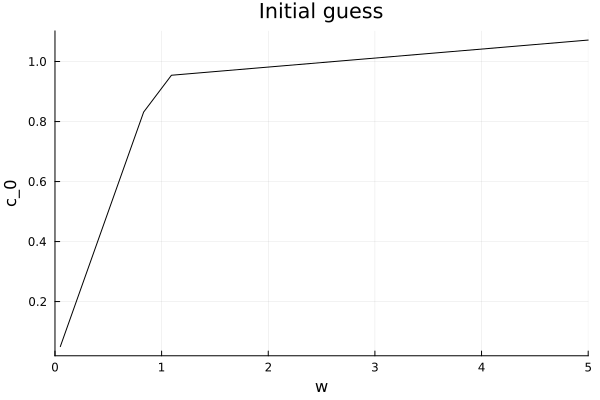

In [4]:
function φ_0(w::Float64)
    return min(w,approx.p_0 + approx.p_1*(w-approx.p_0))
end

c_0 = φ_0.(approx.points)

fig = plot(xlim=(0,approx.wmax), legend=:bottomright, title="Initial guess", xaxis="w", yaxis="c_0")
plot!(fig, approx.points, c_0, c=:black, label="")

In [5]:
#! ----------------------------------------
#!       Linear interpolation of φ_0
φ = linear_interpolation(approx.points,c_0; extrapolation_bc=Line())
#! ----------------------------------------

println(φ(5.0)) # point on the grid
println(φ(0.1)) # point not on the grid : interpolate

1.0715
0.1


In [6]:
φ(5.030041002239343)

1.0724012300671801

## (2) Discretizing $\epsilon_{t+1}$

**Represent the shock $\epsilon$ by two vectors $(e_1, ... e_q)$ and
$(l_1, ..., l_q)$ with $q=10$ such that for a suitable function $g$ we
can approximate $E_{\epsilon} (g(\epsilon))$ by $\sum_{i=1}^q l_i e_i$**


- Monte Carlo : $Ê[f(X)] \coloneqq \frac{1}{N}\sum f(x_i)$ 
- Quantization using quantiles to alleviate MC's need of a large nb of observations to be precise
    - N = 10 split space in decile 
    - $Ê_{\varepsilon}[g(\varepsilon)] \coloneqq \sum \frac{1}{N} g(x_i)$ where ($1/N$;$\{x_i\}_{i=1\dots N}$) is the quantization

In [7]:
function discret(g::Function, d; q=10)
    e = [ quantile(d,1/(2*q) + i/q) for i=0:(q-1) ]     # 'Quantization using quintiles' slide
    e = g.(e)
    l = 1/q
    return (; est=sum(l*e), e=e, l=[1/q for i=1:length(e)])
end

discret (generic function with 1 method)

**Test that it works by computing
$E_{\epsilon} \left[ \epsilon^2 \right]$.**

In [8]:
# 'est' is the estimated value
discret(u->u^2,d)

(est = 8.797873367997104e-5, e = [0.0002705543454095415, 0.00010741941708575855, 4.5493642311957284e-5, 1.4847186183254549e-5, 1.5790774093431222e-6, 1.5790774093431256e-6, 1.4847186183254549e-5, 4.5493642311957284e-5, 0.00010741941708575865, 0.0002705543454095417], l = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

**Redefine `approx` so as to include the discretized shock**

In [9]:
approx = (;
        wmax = 5.0,
        N = 20,
        p_0 = 0.95,
        p_1 = 0.03,
        points = Array(LinRange(0.05,5.0,20)),
        discret = discret)

(wmax = 5.0, N = 20, p_0 = 0.95, p_1 = 0.03, points = [0.05, 0.31052631578947365, 0.5710526315789474, 0.8315789473684211, 1.0921052631578947, 1.3526315789473684, 1.6131578947368421, 1.8736842105263158, 2.1342105263157896, 2.394736842105263, 2.6552631578947365, 2.9157894736842107, 3.1763157894736844, 3.4368421052631577, 3.6973684210526314, 3.9578947368421056, 4.218421052631578, 4.478947368421053, 4.739473684210526, 5.0], discret = discret)

## (3) Euler equation

**Write down the Euler equation, paying attention to the slackness
condition.**

It should be of the form
$$0 \leq \underbrace{E_t \left[ f(w_t, c_t, w_{t+1}, c_{t+1}, \epsilon_{t+1}) \right]}_{\Phi_t} \perp c_t \leq w_t$$

where $f$ is a function to be explicited.

**The objective function is :**

$$ 
V(\mathbf{w_0}) \coloneqq \max_{ \color{red}{\{ c_t, i_t, w_{t+1} \}}_{t\geq 0} } E_0 \left[ \sum_{t} \beta^t U(c_t) \right] \\ \; \\
s.c \; \begin{cases} \begin{align*} 
    w_{t+1} & = e^ {\epsilon_{t+1}} +  r i_t \\
    i_t & = w_t - c_t \end{align*} \\
    w_{t+1} > 0, \; c_t > 0 \\
    w_{t+1} < w_{max} \\
    i_t\geq 0 \quad \textrm{{\color{red}\textit{credit constraint}} : no borrowing}
\end{cases}
$$

- $\textrm{\textbf{Pre-determined / State variables}}$
    - $w_t$ is a **pre-determined** variable at date $t$ = **state variables**
    - $c_t$ and $i_t$ are **optimized upon** at date $t$ = **control variables**

> $\textrm{\color{blue}\textbf{Lagrangian solution}}$

$$ 
V(\mathbf{w_0}) \coloneqq \max_{ \color{red}{\{ c_t, w_{t+1} \}}_{t\geq 0} } E_0 \left[ \sum_{t} \beta^t U(c_t) \right] \qquad {\color{green}{U(x) \coloneqq log(x)}} \\ \; \\

s.c \; \begin{cases} \begin{align*} 

w_{t+1} & = e^ {\epsilon_{t+1}} +  r (w_t - c_t) & \Rightarrow & \; {\color{red}\lambda_t} \; (\geq 0)\\

c_t & > 0 & \Rightarrow & \; {\color{red}\mu_t} \; (\geq 0)\\

w_{t+1} & > 0 & \Rightarrow & \; {\color{red}q_t} \; (\geq 0)\\

%w_{max} - w_{t+1} & > 0 & \Rightarrow & \; {\color{red}h_t} \; (\geq 0)\\

c_t & \leq w_t \rightarrow w_t - c_t \geq 0 & \Rightarrow & \; {\color{red}\nu_t} \; (\geq 0) \quad \textrm{{\color{red}\textit{credit constraint}} : no borrowing} \\

\end{align*} \end{cases}
$$

$$\Rightarrow \textrm{{5 variables}}$$ 

$$\forall t \geq 0 \qquad 
\mathcal{L}_t = E_t\left[ \sum_{s \geq 0} \beta^{t+s}
\left\{ \; U(c_{t+s}) + {\color{green} \mu_s} [c_{t+s}] + {\color{green} q_s} [w_{t+1+s}] + {\color{green} \nu_s} [w_{t+s} - c_{t+s}] + {\color{green} \lambda_s} [e^ {\epsilon_{t+s+1}} +  r (w_{t+s} - c_{t+s}) - w_{t+s+1}] \; \right\} \right]
$$

$$\textrm{\textbf{2 FOCs : }} \qquad \forall s \geq 0 \quad \begin{cases} \begin{align*} 
\frac{\partial \mathcal{L}_t}{\partial c_{t+s}} & = & 0 \\ 
\frac{\partial \mathcal{L}_t}{\partial w_{t+1+s}} & = & 0 \\
\end{align*} \end{cases}
$$

$$\textrm{\textbf{KKT {\color{blue}complementary slackness condition} (at optima) : }}$$ 
$$
\begin{cases} \begin{align*}
{\color{blue}\mu_s} & = 0 \quad & \textrm{or} \quad & c_{t+s} = 0 & \rightarrow & \; \textrm{Impossible otherwise $U'(0) = \infty $ } \\
{\color{blue}q_s}   & = 0 \quad & \textrm{or} \quad & w_{t+s+1} = 0 & \rightarrow & \; \textrm{Impossible because $e^ {\epsilon_{t+1+s}}>0$ } \\
\end{align*} \end{cases}
$$
$$
\textrm{\textbf{\textit{and} }} \qquad \begin{cases} \begin{align*}
E_t\left[ e^ {\epsilon_{t+s+1}} +  r (w_{t+s} - c_{t+s}) - w_{t+s+1} \right] & \geq 0 \; {\color{red}\perp} \; \lambda_{s} \geq 0 \\
E_t\left[ w_{t+s} - c_{t+s} \right]                                          & \geq 0 \; {\color{red}\perp} \; \nu_{s} \geq 0 \quad \textrm{{\color{red}\textit{credit constraint}}}
\end{align*} \end{cases}
$$

> $\textrm{\color{blue}\textbf{(1) Solving WITHOUT credit constraint}}$

$$\textrm{\textbf{FOCs : }} \forall s \geq 0 \quad 
\begin{cases} \begin{align*} 
\frac{\partial \mathcal{L}_t}{\partial c_{t+s}}   & = & \beta^{t+s} E_t \left\{ U'(c_{t+s}) - r\lambda_s \right\} = 0\\ 
\frac{\partial \mathcal{L}_t}{\partial w_{t+1+s}} & = & E_t \left\{ \beta^{t+1+s}r\lambda_{s+1} - \beta^{t+s}\lambda_{s} \right\} = 0 \\
\end{align*} \end{cases}

\quad \rightarrow \quad

\begin{cases} \begin{align*} 
E_t \left\{ U'(c_{t+s})\right\} & = & r\lambda_s \\ 
\beta r\lambda_{s+1}               & = & \lambda_{s} \\
\end{align*} \end{cases}

\quad \rightarrow \quad

\begin{cases} \begin{align*} 
r \beta \frac{ E_t \left\{ U'(c_{t+s+1}) \right\}}{E_t \left\{ U'(c_{t+s}) \right\}} = 1
\end{align*} \end{cases}
$$

$$ \textrm{\textbf{Optimality condition - Euler equation ({\color{red}\textit{NO credit constraint}}) : \quad }} 
r \beta E_t \left\{ \; \frac{U'(c_{t+1})}{U'(c_{t})} \; \right\} = 1
$$

> $\textrm{\color{blue}\textbf{(2) Solving WITH credit constraint}}$

$$\textrm{\textbf{FOCs : }} \forall s \geq 0 \quad 
\begin{cases} \begin{align*} 
\frac{\partial \mathcal{L}_t}{\partial c_{t+s}}   & = & \beta^{t+s} E_t \left\{ U'(c_{t+s}) - r\lambda_s - {\color{green} \nu_s} \right\} = 0 \\ 
\frac{\partial \mathcal{L}_t}{\partial w_{t+1+s}} & = & E_t \left\{ \beta^{t+1+s}({\color{green} \nu_{s+1}} + r\lambda_{s+1}) - \beta^{t+s}\lambda_{s} \right\} = 0\\
\frac{\partial \mathcal{L}_t}{\partial \lambda_s} & = & E_t\left[ e^ {\epsilon_{t+s+1}} +  r (w_{t+s} - c_{t+s}) - w_{t+s+1} \right] = 0 \\ 
\frac{\partial \mathcal{L}_t}{\partial \nu_s}     & = & E_t\left[ w_{t+s} - c_{t+s} \right] = 0 \\ 
\end{align*} \end{cases}
$$

$$
\quad \rightarrow \quad
\begin{cases} \begin{align*} 
 \nu_s + r\lambda_s                                                           & =  E_t \left\{ U'(c_{t+s}) \right\} \\ 
 \lambda_s & = \beta E_t \left\{ U'(c_{t+s+1}) \right\} \\
 %E_t\left[ e^ {\epsilon_{t+s+1}} +  r (w_{t+s} - c_{t+s}) - w_{t+s+1} \right] & = 0 \\ 
 %E_t\left[ w_{t+s} - c_{t+s} \right]                                          & = 0 \\ 
\end{align*} \end{cases}

\quad \rightarrow \quad
\begin{cases} \begin{align*} 
 \nu_s                                                                        & =  E_t \left\{ U'(c_{t+s}) \right\} - r\beta E_t \left\{ U'(c_{t+s+1}) \right\} \geq 0\\ 
 \lambda_s                                                                    & = \beta E_t \left\{ U'(c_{t+s+1}) \right\} {\color{red}{>0}}\\
 %E_t\left[ e^ {\epsilon_{t+s+1}} +  r (w_{t+s} - c_{t+s}) - w_{t+s+1} \right] & = 0 \\ 
 %E_t\left[ w_{t+s} - c_{t+s} \right]                                          & = 0 \\ 
\end{align*} \end{cases}
$$

$$
E_t\left[ w_{t+s} - c_{t+s} \right] \geq 0 \; {\color{red}\perp} \; \nu_{s} \geq 0 \quad 
\textrm{{\color{red}\textit{credit constraint}} \, becomes : \quad} 
E_t\left[ w_{t+s} - c_{t+s} \right] \geq 0 \; {\color{red}\perp} \; E_t \left[ U'(c_{t+s}) - r\beta U'(c_{t+s+1}) \right] \geq 0
$$

$$ \textrm{\textbf{Optimality condition - Euler equation ({\color{red}\textit{WITH credit constraint}}) : \quad }} 
w_{t} - c_{t} \geq 0 \; {\color{red}\perp} \; U'(c_{t}) - r\beta E_t \left[ U'(c_{t+1}) \right] \geq 0 
$$

$$ \textrm{\textbf{\color{blue}Fisher-Burmeister : }} \quad 
\mathcal{FB}(w_{t} - c_{t} \; ; \; U'(c_{t}) - r\beta E_t \left[ U'(c_{t+1}) \right]) = 0 
\rightarrow \mathcal{FB}(w_{t} - c_{t} \; ; \; \Phi_t ) = 0 
$$

**Define the function `Phi(w::Float64,c::Float64,φ::Fun, model, approx)`
which approximates the residuals of the euler equation given the
available income today, the consumption choice today, the consumption
*function* tomorrow and the model/approx structures.**

$\color{red}\textrm{We have :}\quad E_t[U'(c_{t+1})] = E_t\left[ \frac{1}{c_{t+1}} \right] = E_{\epsilon}\left[ \frac{1}{\tilde{φ}(w_{t+1}(\epsilon_{t+1}))} \right] \quad \textrm{as we chose } U(x)=log(x)$ 

- **where $\tilde{φ}$ = consumption function tomorrow (*interpolated*)**
- and $w_{t+1}(\epsilon_{t+1}) = e^ {\epsilon_{t+s+1}} +  r (w_{t} - c_{t}) $
- $\Rightarrow$ use *discret* function to compute the expectation, applied to $g(\epsilon)=1/\tilde{φ}(w_{t+1}(\epsilon))$

In [10]:
function Phi(w, c, φ, model, approx)
    (;β, r) = model
    (;discret) = approx
    res = 1/c - r*β*discret(u->1/φ(exp(u)+r*(w-c)), d).est
    return res
end

Phi (generic function with 1 method)

**Overload `Phi` function with another method
`Phi(w::Float64,c::Float64,φ::Fun, model, approx, slackness=true)` which
uses the Fisher-Burmeister transform to *incorporate the credit constraint*.**

In [11]:
function Phi(w, c, φ, model, approx, slackness)
    a = w-c
    b = Phi(w, c, φ, model, approx)
    res = a + b - sqrt(a^2+b^2)
    return res
end

Phi (generic function with 2 methods)

In [12]:
#! Allow for Dual number, as we use ForwardDiff.derivative later on !
Phi(w::ForwardDiff.Dual, c::ForwardDiff.Dual, φ, model, approx, slackness) = Phi(w.value, c.value, φ, model, approx, slackness)

Phi (generic function with 3 methods)

**Plot the optization residuals (i.e. values of $\Phi_t$) corresponding
to the initial guess function with and without the complementarity
constraints.**

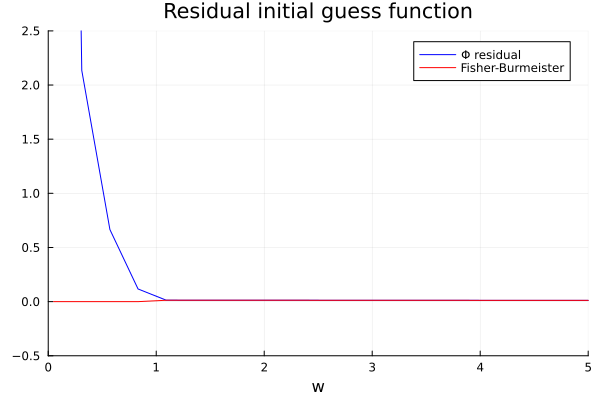

In [13]:
fig = plot(xlim=(0,approx.wmax), ylim=(-0.5, 2.5), legend=:topright, title="Residual initial guess function", xaxis="w")
plot!(fig, approx.points, [ Phi(w, φ(w), φ, model, approx) for w in approx.points ], c=:blue, label= "Φ residual")
plot!(fig, approx.points, [ Phi(w, φ(w), φ, model, approx, true) for w in approx.points ], c=:red, label= "Fisher-Burmeister")

## (4) Time Iteration

**(prep): Assuming the initial guess $φ_0()$ is the decision rule followed tomorrow, determine, for a given value `w` in the state-space, the optimal consumption choice made today. This can be achieved by feeding the appropriate function into the right nonlinear root-finder.**

$$ \textrm{\textbf{Optimality condition - Euler equation ({\color{red}\textit{WITH credit constraint}}) : \quad }} 
w_{t} - c_{t} \geq 0 \; {\color{red}\perp} \; U'(c_{t}) - r\beta E_t \left[ U'(c_{t+1}) \right] \geq 0 
$$

$$ \textrm{\textbf{\color{blue}Fisher-Burmeister : }} \quad 
\mathcal{FB}(w_{t} - c_{t} \; ; \; U'(c_{t}) - r\beta E_t \left[ U'(c_{t+1}) \right]) = 0 \quad \textrm{where $c_{t+1}$ depends on the decision rule followed \textbf{tomorrow} as seen previously} \\ \; \\
\rightarrow \mathcal{FB}(w_{t} - c_{t} \; ; \; \Phi_t ) = 0 
\rightarrow " F(c_{t}) " = 0
\quad \Rightarrow \textrm{Root finding solver} \; \\ \; \\
\textrm{\textbf{Solution Firsher-Burmeister : }} \; \rightarrow \; c_{t}^{\star} \quad \textrm{optimal consumption choice made \textbf{today} (given the decision rule $\tilde{φ}$ for tomorrow)}
$$

**------------------------------------------------------------------------------------------------------**

**Compute the optimal consumption $c_t$ given $w_t$ (*state*) and the decision rule followed tomorrow $\tilde{φ}$**

**------------------------------------------------------------------------------------------------------**

In [14]:
#! Compute the optimal consumption C given W (state) and the decision rule followed tomorrow φ
#! ===> Look for a root using 
function opti_C(w, φ, model, approx; verbose=false, N=20)

# discret(u->1/φ( exp(u)+r*(w-c) ), d).est

    function zero_newton(f::Function, x_0::Float64; N=N, τ_ϵ=10^(-15), verbose)
        x_L = Float64[]
        push!(x_L,x_0)
        ϵ = abs(f(x_0))
    
        for i in 1:N
            x_0 = x_L[end]
            df = ForwardDiff.derivative(f,x_0)
            x_0 = x_0 - f(x_0)/df
            push!(x_L,x_0)
            ϵ = abs(f(x_0))
            if verbose
                println("Iteration $(i):")
                println("c = $(x_0)")
                println("ϵ = $(ϵ)")
                println("---------------")
            end
            if ϵ<τ_ϵ
                #return (;x=x_0, x_L, ϵ, N)
                return x_0
            end
        end
        error("No convergence opti_C (Newton)")
    end

    FB_ = ( u -> Phi(w, u, φ, model, approx, true) )
    # initial guess c_0 = w/2 arbitrary
    res = zero_newton(FB_, w/2; verbose=verbose)
    return res
end

# Exemple : 
# opti_C(3.0, φ, model, approx; verbose=true)

opti_C (generic function with 1 method)

**(prep): Find the vector of all the optimal consumption choices on the
grid today, given the decision rule tomorrow.**

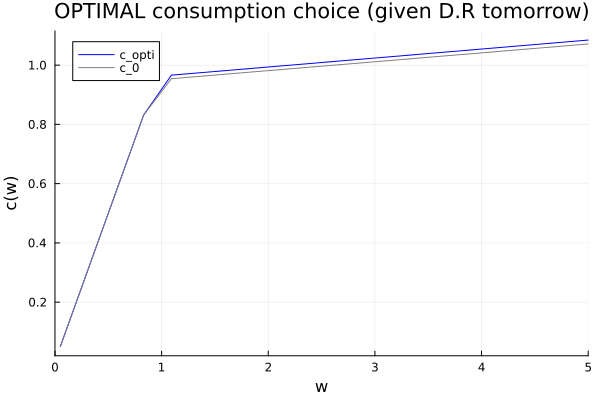

In [15]:
fig = plot(xlim=(0,approx.wmax), legend=:topleft, title="OPTIMAL consumption choice (given D.R tomorrow)", xaxis="w", yaxis="c(w)")
plot!(fig, approx.points, [ opti_C(w, φ, model, approx) for w in approx.points ], c=:blue, label= "c_opti")
plot!(fig, approx.points, [ φ(w) for w in approx.points ], c=:gray, label= "c_0")

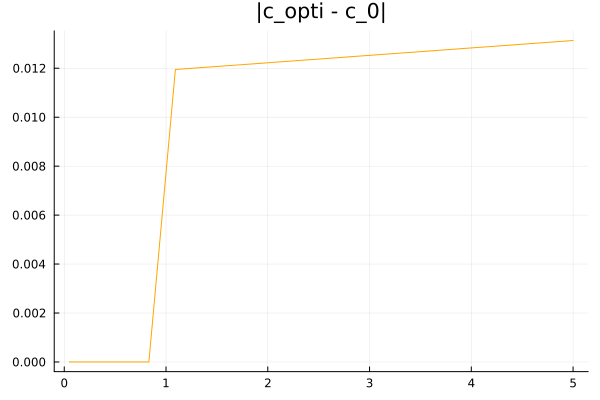

In [16]:
# Different after one step :
plot(approx.points, [ abs(opti_C(w, φ, model, approx) - φ(w)) for w in approx.points ], c=:orange, title="|c_opti - c_0|", label="")

**(prep) Plot the optimization residuals (i.e. values of $\Phi_t$) for the initial guess function**

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/prld/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/prld/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/prld/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/prld/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/prld/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/prld/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/prld/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


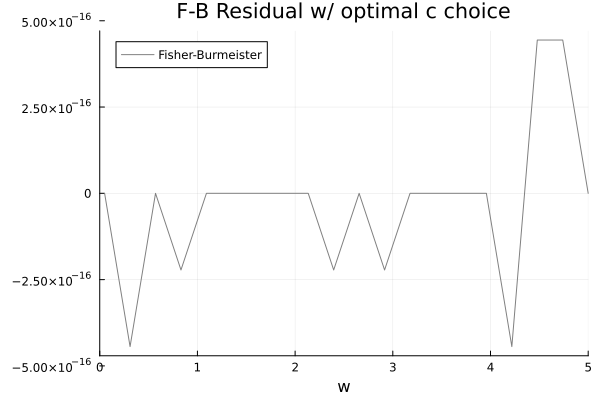

In [17]:
fig = plot(xlim=(0,approx.wmax), title="F-B Residual w/ optimal c choice", xaxis="w")
plot!(fig, approx.points, [ Phi(w, opti_C(w, φ, model, approx), φ, model, approx, true) for w in approx.points ], c=:gray, label= "Fisher-Burmeister")
# >> Optimization residual = 0, good!

# --- 
#! < Warning: No strict ticks found >
# Difference between plotted points is <1e-15 : it seems Plots does not to like that for the vertical ticks.. (cf optimize_ticks function of Plots)
# --- 

**>> Given the (initial) decision rule tomorrow, we indeed have found the *optimal choice* $c_t^\star = c_t(w_t)$ for today as $\; \forall w, \; F(c_t(w)) \approx 0$**

**Write down the time-iteration algorithm.**

You can use the course as reference and/or repeat the recurrence steps
below:

-   given an initial guess for the consumption vector `c0`
-   create a function defined `φ` on `[0,wmax]` which interpolates `c0`
    on the grid
-   for each grid point `w` in the grid, solve the system
    `u->Phi(w,u,φ, model, approx, slackness=true)`
    -   store the result as a vector `c1`
-   check whether `c1` is close to `c0`
    -   yes: check the system is indeed solved and return
    -   no: start again with `c1` as `c0`

In [18]:
"""
φ0       > Initial guess : either a functional form (u->f(u)) or a vector of Float64 = evaluation of f over the grid
K        > Number of iterations for Time Iteration
N_newton > Number of iterations Newton Root finder (Euler/FB optimality condition)
τ_η      > Convergence threshold 
"""

function time_iteration(φ0, model, approx; K=200, τ_η=10^(-14), N_newton=20)

    local η
    η_L = Float64[]
    φ_L = []

    if (typeof(φ0) <: Function)
        # convert initial function φ0 into a consumption vector by evaluating φ on the grid
        c0 = φ0.(approx.points)
    else
        # else : φ0 would be a Vector{Float64} if I try to use time_iteration on a previous output c_rule 
        c0 = φ0
    end
    push!(φ_L,c0)

    for k=1:K

        # > convert consumption vector c0 into a function φ
        φ = linear_interpolation(approx.points,c0; extrapolation_bc=Line())
        
        # > solve for the optimal consumption for all grid points
        c1 = [ opti_C(w, φ, model, approx; verbose=false, N=N_newton) for w in approx.points ]

        # > check distance between c0 and c1
        η = maximum(abs.(c1-c0))
        push!(η_L,η)
        c0 = c1
        push!(φ_L,c0)
        if η<τ_η
            println(">> Converged in $(k) iterations! ")
            return (;c_rule = c0, φ_L, η_L) 
        end

    end
    error("No convergence Time Iteration")
end

time_iteration (generic function with 1 method)

In [19]:
test_res = time_iteration(φ_0, model, approx)

>> Converged in 94 iterations! 


(c_rule = [0.05000000000000097, 0.31052631578947393, 0.5710526315789474, 0.8315789473684211, 1.0180791578855026, 1.0693658578689977, 1.1052189761524382, 1.134660380755196, 1.1604658369493839, 1.18388265955886, 1.2055891761778277, 1.2259998677954327, 1.245388774638009, 1.2639477072799572, 1.2818168374706707, 1.2991021194202388, 1.315885848611907, 1.3322333877323438, 1.3481972968800917, 1.3638197020523986], φ_L = Any[[0.05, 0.31052631578947365, 0.5710526315789474, 0.8315789473684211, 0.9542631578947368, 0.962078947368421, 0.9698947368421053, 0.9777105263157895, 0.9855263157894736, 0.9933421052631578, 1.001157894736842, 1.0089736842105264, 1.0167894736842105, 1.0246052631578946, 1.032421052631579, 1.040236842105263, 1.0480526315789473, 1.0558684210526315, 1.0636842105263158, 1.0715], [0.04999999999999925, 0.31052631578947404, 0.5710526315789474, 0.8315789473684213, 0.9662128954095229, 0.9741076329103974, 0.9820023704006796, 0.9898971078806236, 0.9977918453504736, 1.005686582810468, 1.0135

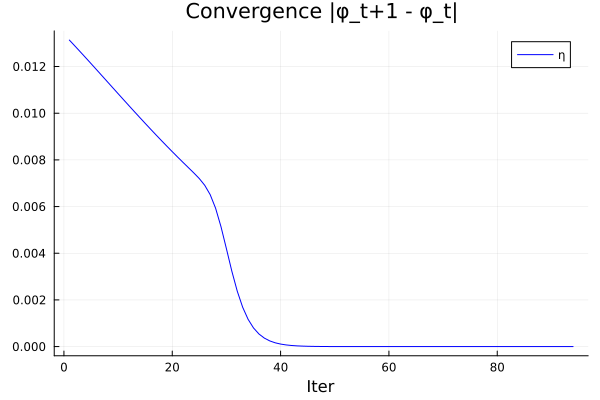

In [20]:
plot(test_res.η_L, title="Convergence |φ_t+1 - φ_t|", label="η", c=:blue, xaxis="Iter")

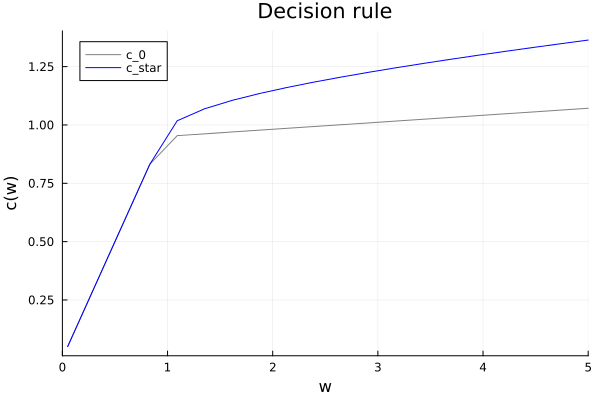

In [21]:
fig = plot(xlim=(0,approx.wmax), legend=:topleft, title="Decision rule", xaxis="w", yaxis="c(w)")
plot!(fig, approx.points, c_0, c=:gray, label= "c_0")
plot!(fig, approx.points, test_res.c_rule, c=:blue, label= "c_star")

>> Converged in 102 iterations! 


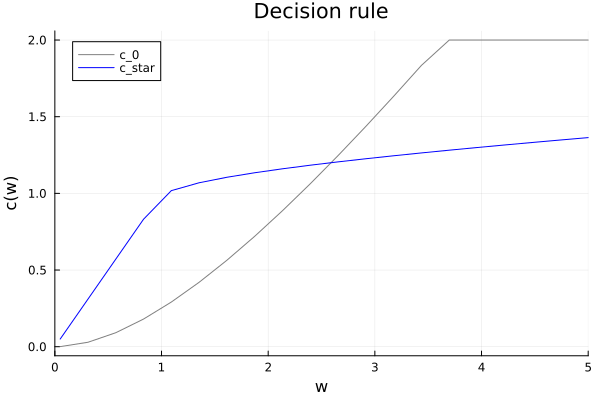

In [22]:
# Testing with another initial guess for fun :)

fig = plot(xlim=(0,approx.wmax), legend=:topleft, title="Decision rule", xaxis="w", yaxis="c(w)")
plot!(fig, approx.points, (u->min(u^2/(u+3),2.0)).(approx.points) , c=:gray, label= "c_0")
plot!(fig, approx.points, time_iteration( (u->min(u^2/(u+3),2.0)) , model, approx; N_newton=100).c_rule, c=:blue, label= "c_star")

**Check that the value returned by `time_iteration` is actually a
solution to the system. How fast is the convergence? Graphical
representation.**

In [23]:
check_res = time_iteration(test_res.c_rule, model, approx)

# >> Immediate convergence ! Good sign

maximum(abs.(check_res.c_rule - test_res.c_rule))

>> Converged in 1 iterations! 


5.773159728050814e-15

In [24]:
# Residual of the Euler equation / Fischer-Burmeister w credit constraint : 
φ_star = (u->linear_interpolation(approx.points,test_res.c_rule; extrapolation_bc=Line())(u))   # NB: convert c_rule into an actual function... necessary in Phi as φ (decision rule 'tomorrow') is used a function in the expectation evaluation

maximum(abs.([ Phi(approx.points[i], test_res.c_rule[i], φ_star, model, approx, true) for i=1:approx.N]))

# Optimality condition satisfied !

3.1086244689504383e-15

## Bonuses


**(easy): perform some sensitivity analysis on the model to explain the
effect of the main parameters**

**(medium): Given the solution to the above problem, simulate the law of
motion for the available income. Find a way to plot the distriution of
that income over a long period of time.**

**(hard): Propose and implement some ideas to speed up the solution
process.**

One promising avenue consists in solving for all consumption values at
all grid points as one single system of equation after recognizing that
the jacobian of this particular system has a specific structure.